# Design Single Country Nat Cat Bonds

In [2]:
#import generald packages
import numpy as np

#import climada stuff
from climada.hazard import tc_tracks, Centroids, TropCyclone
from climada.entity import LitPop
from climada.util.api_client import Client
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.engine import ImpactCalc
import functions as fct


client = Client()

c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


### Load TC Tracks

In [54]:
#load TC tracks by importing storm data set into a dictionary
basin = 'NA'

storms = {}

storms = {
    f"storm_{i:02}": tc_tracks.TCTracks.from_simulations_storm(
        f"C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/storm_tc_tracks/STORM_DATA_IBTRACS_{basin}_1000_YEARS_{i}.txt"
    )
    for i in range(10)
}

key_00 = next(iter(storms))
storms_NA = storms[key_00]

for key in list(storms.keys())[1:]:
        storms_NA.append(storms[key].data)

print(storms_NA.size)


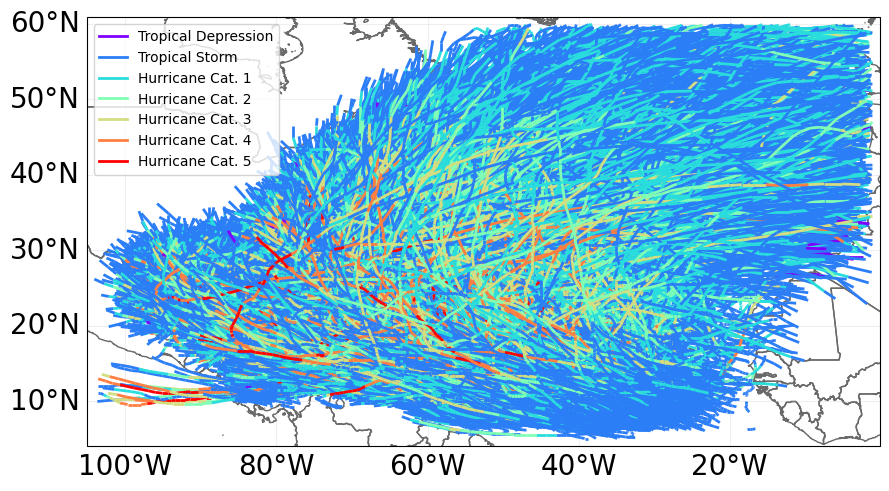

In [4]:
#illustrate TC tracks for one index data set
ax = storms_NA.plot()
ax.get_legend()._loc = 2

### Generate Exposure Data 
    a) Generate exposure data using newest available data by myself. Can choose fin_mode myself. <br>
    b) Download readily calculated exposure data using the Data API from CLIMADA. Exposure is based on data from 2014 and based on fin_mode produced capital. Exponents = 1,1; 30arcsec grid 

In [ ]:
#Generate exposure data
exp_jam_ind = LitPop.from_countries('JAM', fin_mode='pc', reference_year=2023, res_arcsec=300)
#show and plot exposure data
exp_jam_ind.gdf.head()
exp_jam_ind.plot_raster()
exp_jam_ind.plot_scatter()

<GeoAxes: title={'center': "LitPop Exposure for ['JAM'] at 150 as, year: 2018, financial mode: pc,\nexp: (1, 1), admin1_calc: False"}>

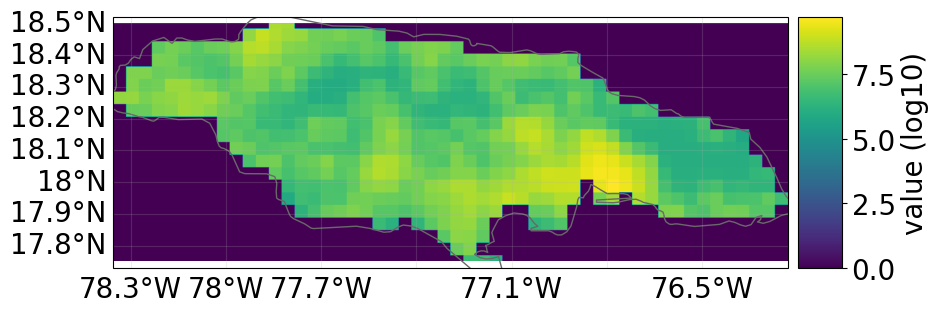

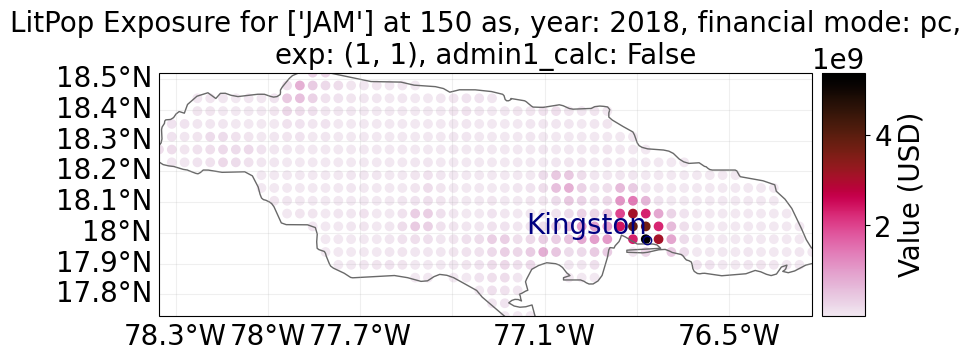

In [94]:
#download readily calculated exposure data
exp_jam_gen = client.get_litpop(country='JAM')
#show and plot exposure data
exp_jam_gen.gdf.head()
exp_jam_gen.plot_raster()
exp_jam_gen.plot_scatter()

### Generate TC Class

In [ ]:
filter

c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:308: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_buffer = exposure.gdf.buffer(distance=buffer, resolution=0)
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\shapely\constructive.py:181: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry colu

128


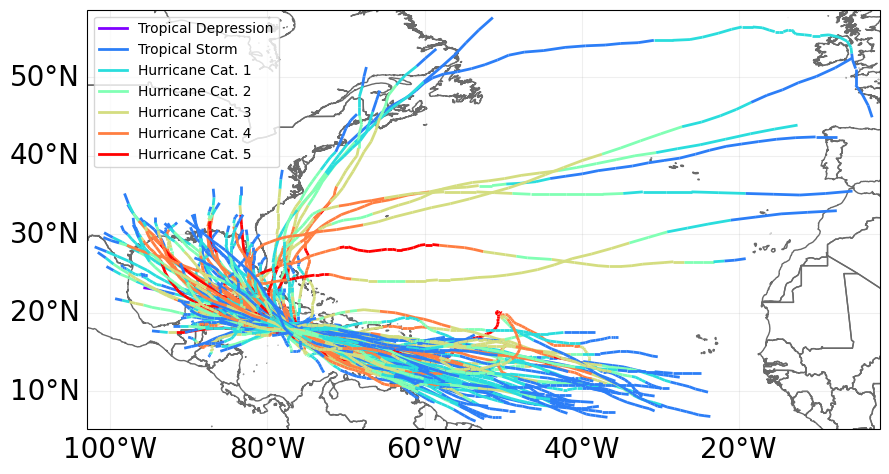

In [95]:
#filter tc tracks which are located close to exposure values
storm_00_sub = storm_00.tracks_in_exp(exp_jam_gen, buffer=0.1)
print(storm_00_sub.size)
ax_sub = storm_00_sub.plot()
ax_sub.get_legend()._loc = 2

#storms_sub = {}

#for i in range(10):
#    storm_key = f"storm_{i:02}" 
#    storm_sub_key = f"tc_{storm_key}"  
    
    # Perform the operation and store it in the tc_storms dictionary
#    storms_sub[storm_sub_key] = storms[storm_key].tracks_in_exp(exp_jam_gen, buffer=0.1)


C:\Users\kaibe\AppData\Local\Temp\ipykernel_34324\3605695988.py:4: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)


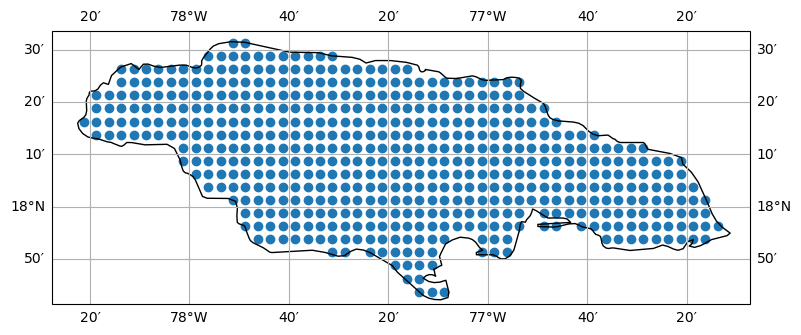

In [124]:
# construct centroids from the exposure position
lat = exp_jam_gen.gdf['latitude'].values
lon = exp_jam_gen.gdf['longitude'].values
centrs = Centroids.from_lat_lon(lat, lon)
centrs.plot();

#define frequency correction factor
freq_corr_STORM = 1/1000

#generate TropCyclone class from previously loaded TC tracks for one storm data set
tc_storm_00 = TropCyclone.from_tracks(storm_00_sub, centroids=centrs)
tc_storm_00.frequency = np.ones(tc_storm_00.event_id.size) * freq_corr_STORM
tc_storm_00.check()

#generate TropCyclone class from previously loaded TC tracks for all storm data sets and store the in a dictionary
#tc_storms = {}

#for i in range(10):
#    storm_key = f"storm_{i:02}"  # e.g., 'storm_00'
#    tc_storm_key = f"tc_{storm_key}"  # e.g., 'tc_storm_00'
    
    # Perform the operation and store it in the tc_storms dictionary
#    tc_storms[tc_storm_key] = TropCyclone.from_tracks(storms[storm_key], centroids=centrs)
#    tc_storms[tc_storm_key].frequency = np.ones(tc_storms[tc_storm_key].event_id.size) * freq_corr_STORM


### Calculate Impact

In [125]:
#import regional calibrated impact function for TC
impf_set = trop_cyclone.ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()
impf_set.check()

In [126]:
#compute impact
imp = ImpactCalc(exp_jam_gen, impf_set, tc_storm_00).impact(save_mat=True)

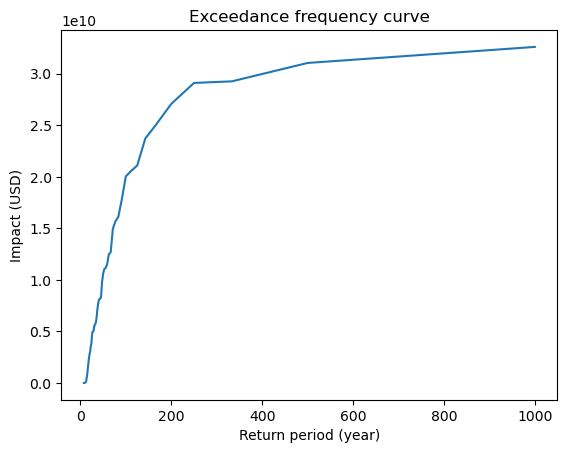

In [127]:
#compute exceedance frequency curve
freq_curve = imp.calc_freq_curve()
freq_curve.plot()
imp.aai_agg
imp_ev = imp.at_event